In [65]:
import pandas as pd
import numpy as np
from statsmodels.stats import weightstats
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [77]:
df = pd.read_csv("us_health_insurance_cleanednull.csv")

### 1. Phân tích hai biến: Nhân khẩu học (Demographic) tác động như thế nào?

#### Kiểm định giả thuyết 1: Con trai và con gái sử dụng bảo hiểm y tế như nhau.
H0: μ(`charges`)[`'is_male' == 1`] = μ(`charges`)[`'is_male' == 0`]

H1: μ(`charges`)[`'is_male' == 1`] != μ(`charges`)[`'is_male' == 0`]

In [78]:
df['is_male'].value_counts()

is_male
1    677
0    662
Name: count, dtype: int64

In [79]:
male_charges = df[df['is_male'] == 1]['charges'].dropna()
female_charges = df[df['is_male'] == 0]['charges'].dropna()

male_charges_array = np.array(male_charges)
female_charges_array = np.array(female_charges)

variance_male = male_charges_array.var(ddof=1)
variance_female = female_charges_array.var(ddof=1)

print(f'Phương sai của giới tính nam: {variance_male:.2f}')
print(f'Phương sai của giới tính nữ: {variance_female:.2f}')

Phương sai của giới tính nam: 9947842899.12
Phương sai của giới tính nữ: 10137250829.01


In [80]:
alpha = 0.05
confidence_level = 1 - alpha

col1 = weightstats.DescrStatsW(male_charges)
col2 = weightstats.DescrStatsW(female_charges)
cm_obj = weightstats.CompareMeans(col1, col2)
zstat, pvalue = cm_obj.ztest_ind(usevar='unequal')

if (pvalue < alpha):
    print(f'Trị số p = {pvalue:.4f} < {alpha}',
          'nên bác bỏ H0.\n=> μ[Male] != μ[Female]')
else:
    print(f'Trị số p = {pvalue:.4f} >= {alpha}',
          'nên chấp nhận H0.\n=> μ[Male] == μ[Female]')

Trị số p = 0.2685 >= 0.05 nên chấp nhận H0.
=> μ[Male] == μ[Female]


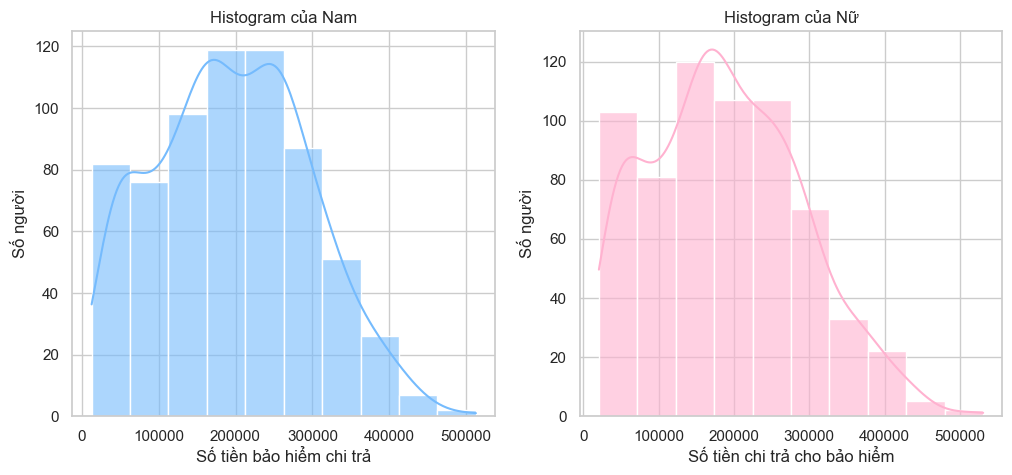

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(male_charges, bins=10, color=sns.xkcd_rgb['sky blue'],
             alpha=0.6, kde=True, ax=ax1)
ax1.set_title('Histogram của Nam')
ax1.set_xlabel('Số tiền bảo hiểm chi trả')
ax1.set_ylabel('Số người')

sns.histplot(female_charges, bins=10, color=sns.xkcd_rgb['powder pink'],
             alpha=0.6, kde=True, ax=ax2)
ax2.set_title('Histogram của Nữ')
ax2.set_xlabel('Số tiền chi trả cho bảo hiểm')
ax2.set_ylabel('Số người')
plt.show()

#### Kiểm định giả thuyết 2: Số lần trung bình đóng lại bảo hiểm y tế của nhóm cao tuổi (người từ 60 tuổi trở lên) không ít hơn 39 lần.
H0: μ(`insur_renewals`)_[`'age' >= 60`] >= 39

H1: μ(`insur_renewals`)_[`'age' >= 60`] < 39

In [82]:
def zDistribution(side, lower, upper):
    side = side.lower()
    if (side == 'left'):
        p = stats.norm.cdf(lower)
    elif (side == 'right'):
        p = 1 - stats.norm.cdf(upper)
    else:
        p = stats.norm.cdf(upper) - stats.norm.cdf(lower)
    return p

In [83]:
elder_renewals = df[(df['age'] >= 50) & (df['age'] <= 64)]['insur_renewals']
renewals_count = elder_renewals.value_counts()

In [84]:
alpha = 0.05
confidence_level = 1 - alpha
Muy0 = 39
n = len(elder_renewals)
ddof = n - 1
xBar = np.mean(elder_renewals)
std = np.std(elder_renewals)

z_stat = (xBar - Muy0) / (std / (n ** .5))
print(f'Trị thống kê z_stat = {z_stat:.2f}')

Trị thống kê z_stat = -8.98


In [85]:
p = zDistribution('left', z_stat, ddof)
if (p < alpha):
    print(f'Trị số p = {p} < {alpha:.4f}',
          f'nên bác bỏ H0.\n=> {Muy0} > μ')
else:
    print(f'Trị số p = {p} >= {alpha:.4f}',
          f'nên chấp nhận H0.\n=> {Muy0} <= μ')

Trị số p = 1.4100504130977438e-19 < 0.0500 nên bác bỏ H0.
=> 39 > μ


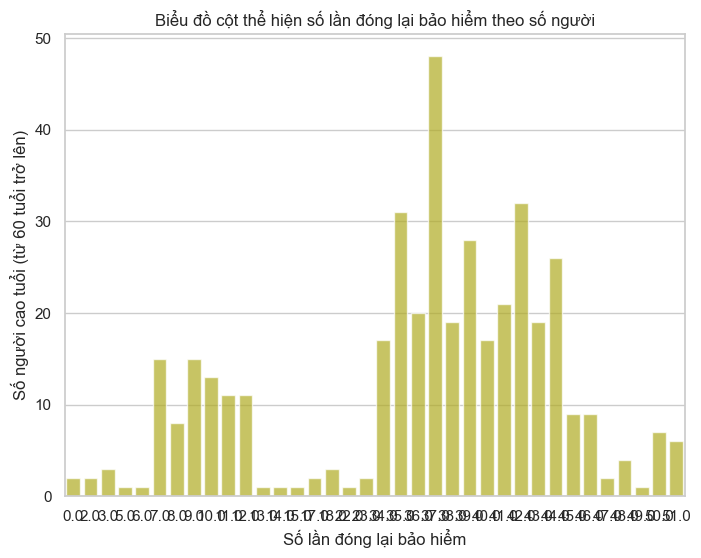

In [86]:
plt.figure(figsize=(8, 6))
sns.barplot(x=renewals_count.index, y=renewals_count.values,
            color=sns.xkcd_rgb['vomit yellow'], alpha=0.7)
plt.xlabel('Số lần đóng lại bảo hiểm')
plt.ylabel('Số người cao tuổi (từ 60 tuổi trở lên)')
plt.title('Biểu đồ cột thể hiện số lần đóng lại bảo hiểm theo số người')
plt.show()

#### Kiểm định giả thuyết 3: Chỉ số sức khỏe BMI không làm ảnh hưởng đến quyết định làm mới bảo hiểm của khách hàng.

In [49]:
df_stand = df.loc[ (18.5 < df["bmi"]) & (df["bmi"] < 24.9)]
df_nstand = df.loc[(18.5 >= df["bmi"]) | (df["bmi"] >= 24.9)]

bmi_stand = df_stand["insur_renewals"]
bmi_nstand = df_nstand["insur_renewals"]

In [88]:
print(f'Số quan sát của mẫu bmi chuẩn: {bmi_stand.shape[0]}// Giá trị trung bình: {bmi_stand.mean():.4f} ')
print(f'Số quan sát của mẫu bmi không chuẩn: {bmi_nstand.shape[0]}// Giá trị trung bình: {bmi_nstand.mean():.4f} ')

Số quan sát của mẫu bmi chuẩn: 362// Giá trị trung bình: 17.6563 
Số quan sát của mẫu bmi không chuẩn: 977// Giá trị trung bình: 25.3954 


In [89]:
print(f'Độ lệch chuẩn của tập chỉ số sức khỏe bình thường: {bmi_stand.std():.4f}')
print(f'Độ lệch chuẩn của tập chỉ số sức khỏe dưới và quá tiêu chuẩn: {bmi_nstand.std():.4f}')
print(f'Độ chênh lệch của std: {abs(bmi_stand.std()-bmi_nstand.std()):4f}' )

Độ lệch chuẩn của tập chỉ số sức khỏe bình thường: 12.9298
Độ lệch chuẩn của tập chỉ số sức khỏe dưới và quá tiêu chuẩn: 12.1274
Độ chênh lệch của std: 0.802419


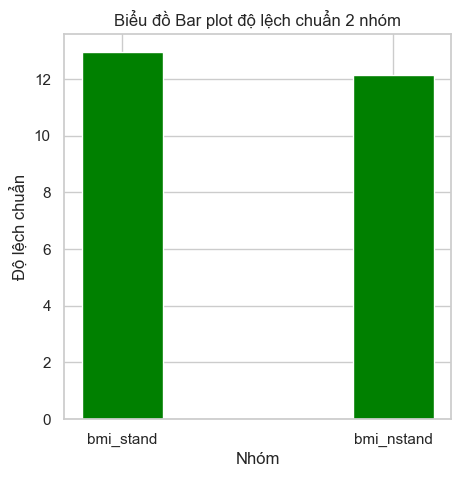

In [90]:
bar_plot = {'bmi_stand' : bmi_stand.std(ddof = 1 ), 'bmi_nstand': bmi_nstand.std(ddof = 1)}
courses = list(bar_plot.keys())
values = list(bar_plot.values())
fig = plt.figure(figsize = (5, 5))

plt.bar(courses, values, color ='green',  width = 0.3)
plt.xlabel("Nhóm")
plt.ylabel("Độ lệch chuẩn")
plt.title("Biểu đồ Bar plot độ lệch chuẩn 2 nhóm")
plt.show()

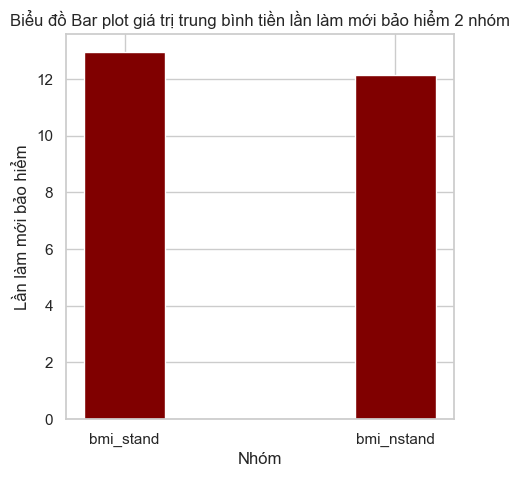

In [91]:
bar_plot = {'bmi_stand' : bmi_stand.mean(), 'bmi_nstand': bmi_nstand.mean()}
fig = plt.figure(figsize = (5, 5))
plt.bar(courses, values, color ='maroon',  width = 0.3)
courses = list(bar_plot.keys())
values = list(bar_plot.values())
plt.xlabel("Nhóm")
plt.ylabel("Lần làm mới bảo hiểm")
plt.title("Biểu đồ Bar plot giá trị trung bình tiền lần làm mới bảo hiểm 2 nhóm")
plt.show()

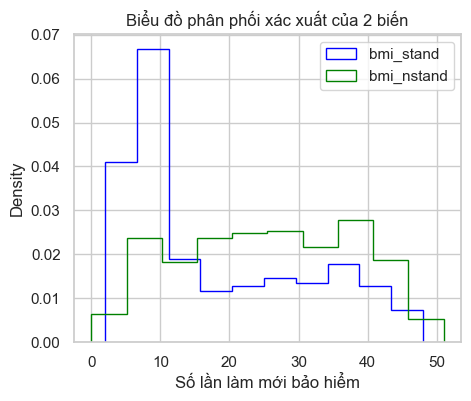

In [92]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
plt.hist(bmi_stand, density = True, histtype = 'step', color = 'blue')
plt.hist(bmi_nstand,  density = True, histtype = 'step', color = 'green')
plt.xlabel('Số lần làm mới bảo hiểm')
plt.ylabel('Density')
plt.title('Biểu đồ phân phối xác xuất của 2 biến')
plt.gca().legend(('bmi_stand','bmi_nstand'))
plt.show()

In [96]:
print(f"Số quan sát trong bmi_stand: {bmi_stand.shape[0]}")
print(f"Số quan sát trong bmi_nstand: {bmi_nstand.shape[0]}")
print(f"Độ lệch chuẩn của bmi_stand: {bmi_stand.std(ddof=1):.4f}")
print(f"Độ lệch chuẩn của bmi_nstand: {bmi_nstand.std(ddof=1):.4f}")

Số quan sát trong bmi_stand: 362
Số quan sát trong bmi_nstand: 977
Độ lệch chuẩn của bmi_stand: 12.9298
Độ lệch chuẩn của bmi_nstand: 12.1274


In [97]:
bmi_stand = bmi_stand.dropna()
bmi_nstand = bmi_nstand.dropna()

In [98]:
alpha = 0.05
z1, p1 = weightstats.ztest(bmi_stand, value = bmi_nstand.mean())

In [99]:
if (p1 < alpha):
    print(f'Trị số p = {p1:} < {alpha:.4f} bác bỏ H0 ==> Chỉ số bmi có ảnh hưởng đến quyết định làm mới bảo hiểm')
else:
    print(f'Trị số p = {p1:} >= {alpha:.4f} KHÔNG bác bỏ H0 => Chỉ số bmi không ảnh hưởng đến quyết định làm mới bảo hiểm ')

Trị số p = 1.6955737664683488e-29 < 0.0500 bác bỏ H0 ==> Chỉ số bmi có ảnh hưởng đến quyết định làm mới bảo hiểm


### 2. Phân tích hai biến: Địa lý (Geography) tác động như thế nào?

#### Kiểm định giả thuyết 4: Các bang ở các vùng khác nhau có xu hướng chi tiền cho bảo hiểm y tế khác nhau.

In [111]:
#Các giá trị của biến region
region = df["region"].unique()
print(region)

['West' 'South' 'Southeast' 'Northeast' 'Midwest']


In [112]:
#Tạo dataframe chứa dữ liệu 2 cột
df1 = df[["region", "insur_renewals"]]
df2 = df1.pivot(columns = "region", values = "insur_renewals" )
new_order = ['West', 'South' ,'Southeast', 'Northeast' ,'Midwest']
df2 = df2[new_order]

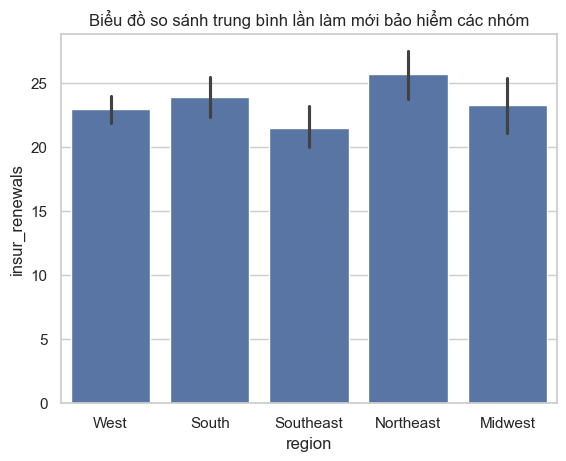

In [115]:

plt.title('Biểu đồ so sánh trung bình lần làm mới bảo hiểm các nhóm')
sns.barplot(x = df1["region"], y = df1["insur_renewals"])
plt.show()

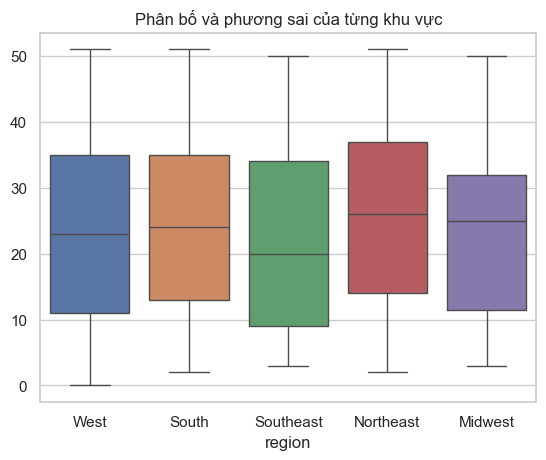

In [116]:
#Box plot thể hiện phân bố và phương sai của từng bang
plt.title("Phân bố và phương sai của từng khu vực")
sns.boxplot( data = df2)
plt.show()

In [117]:
#Mức ý nghĩa alpha = 0.05
alpha = 0.05

#Tách các khu vực thành các cột dữ liệu
West = df2["West"].dropna()
Midwest = df2["Midwest"].dropna()
Northeast = df2["Northeast"].dropna()
South =df2["South"].dropna()
Southeast = df2["Southeast"].dropna()

#Kiểm định ANOVA
f, p = stats.f_oneway(West, Midwest, Northeast, South, Southeast)
if (p < alpha):
    print(f'* Trị số p = {p:.4f} < {alpha:.4f} cho nên bác bỏ H0 ==> có sự khác biệt giữa các khu vực ')
else:
    print(f'* Trị số p = {p:.4f} >= {alpha:.4f} cho nên KHÔNG bác bỏ H0 ==> KHÔNG có sự khác biệt giữa các khu vực')

* Trị số p = 0.0157 < 0.0500 cho nên bác bỏ H0 ==> có sự khác biệt giữa các khu vực 


In [119]:
df2.describe()

region,West,South,Southeast,Northeast,Midwest
count,508.000000,264.000000,233.000000,186.000000,130.000000
mean,22.960630,23.916667,21.506438,25.725806,23.276923
std,12.827732,12.583435,12.819073,13.166505,12.259478
min,0.000000,2.000000,3.000000,2.000000,3.000000
25%,11.000000,13.000000,9.000000,14.000000,11.500000
50%,23.000000,24.000000,20.000000,26.000000,25.000000
75%,35.000000,35.000000,34.000000,37.000000,32.000000
max,51.000000,51.000000,50.000000,51.000000,50.000000


In [120]:
#Bảng Anova
model       = ols('insur_renewals ~ region', data = df1).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,2002.699125,500.674781,3.069526,0.015717
Residual,1316.0,214654.666507,163.111449,NaN,NaN


### 3. Phân tích đa biến: Thói quen và Lối sống tác động như thế nào?

#### Kiểm định giả thuyết 5: Số tiền mà người nghiện thuốc lá chi trả cho bảo hiểm y tế so với người bình thường có giống nhau không? Vậy thì lối sống hút thuốc có ảnh hưởng tới giới tính của mẫu không?

Bài toán 1:

H0: μ(`charges`)[`'smoker' == 1`] = μ(`charges`)[`'smoker' == 0`]

H1: μ(`charges`)[`'smoker' == 1`] != μ(`charges`)[`'smoker' == 0`]

In [124]:
df['smoker'].value_counts()

smoker
0    970
1    369
Name: count, dtype: int64

In [123]:
smoker_charges = df[df['smoker'] == 1]['charges'].dropna()
nonsmoker_charges = df[df['smoker'] == 0]['charges'].dropna()

smoker_charges_array = np.array(smoker_charges)
nonsmoker_charges_array = np.array(nonsmoker_charges)

variance_smoker = smoker_charges_array.var(ddof=1)
variance_nonsmoker = nonsmoker_charges_array.var(ddof=1)

print(f'Phương sai của người nghiện: {variance_smoker:.2f}')
print(f'Phương sai của người bình thường: {variance_nonsmoker:.2f}')

Phương sai của người nghiện: 7915698212.15
Phương sai của người bình thường: 8638125499.50


In [125]:
alpha = 0.05
confidence_level = 1 - alpha
col1 = weightstats.DescrStatsW(smoker_charges_array)
col2 = weightstats.DescrStatsW(nonsmoker_charges_array)
cm_obj = weightstats.CompareMeans(col1, col2)
z, p_value = cm_obj.ztest_ind(usevar='unequal')
if (p_value < alpha):
    print(f'Trị số p = {p_value} < {alpha}',
          'nên bác bỏ H0.\n=> μ[Smoker] != μ[Nonsmoker]')
else:
    print(f'Trị số p = {p_value} >= {alpha}',
          'nên chấp nhận H0.\n=> μ[Smoker] = μ[Nonsmoker]')

Trị số p = 1.0836278881598527e-58 < 0.05 nên bác bỏ H0.
=> μ[Smoker] != μ[Nonsmoker]


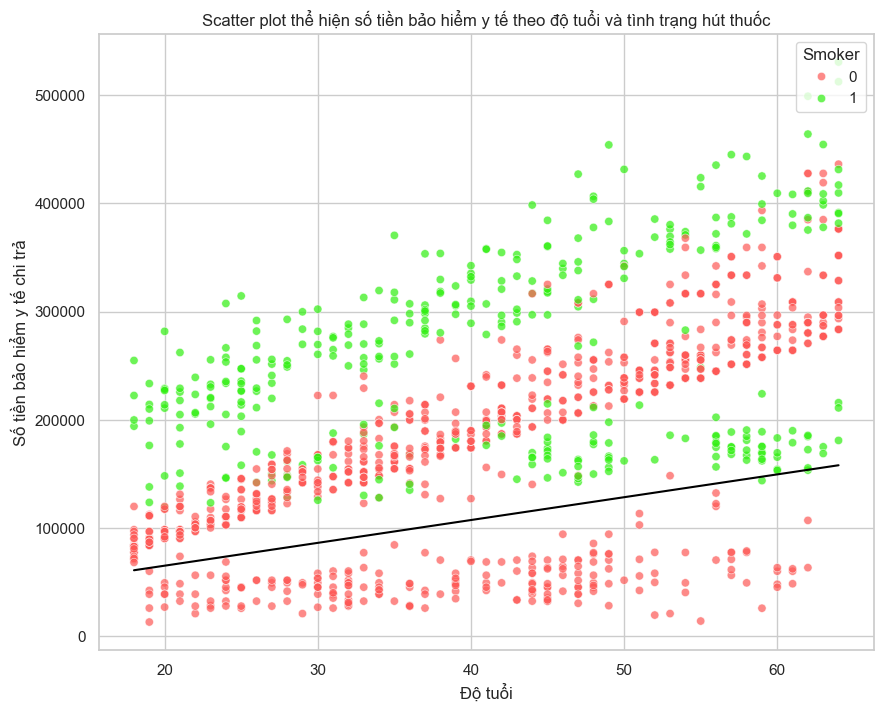

In [126]:
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(x='age', y='charges', hue='smoker', data=df,
                palette=[sns.xkcd_rgb['grapefruit'], sns.xkcd_rgb['vivid green']], alpha=0.7)
plt.xlabel('Độ tuổi')
plt.ylabel('Số tiền bảo hiểm y tế chi trả')
plt.title('Scatter plot thể hiện số tiền bảo hiểm y tế theo độ tuổi và tình trạng hút thuốc')

x_values = np.array([20, 65])
y_values = np.array([65000, 160000])
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
plt.plot(df['age'], polynomial(df['age']), color='black', linestyle='-')
handles, labels = scatter_plot.get_legend_handles_labels()
scatter_plot.legend(handles=handles[:2], labels=labels[:2], loc='upper right', title='Smoker')
plt.show()

Bài toán 2:

H0: `'is_male'` và `'smoker'` là hai biến độc lập

H1: `'is_male'` và `'smoker'` là hai biến phụ thuộc

In [127]:
sex_smoker_crosstab = pd.crosstab(df['is_male'], df['smoker'],
                                  margins=True, margins_name='Tổng cộng')
sex_smoker_crosstab

smoker,0,1,Tổng cộng
is_male,,,
0,482,180,662
1,488,189,677
Tổng cộng,970,369,1339


In [ ]:
alpha = 0.05
confidence_level = (1 - alpha)
stat, p, ddof, expected = stats.chi2_contingency(sex_smoker_crosstab)

In [129]:
critical = stats.chi2.ppf(confidence_level, ddof)
print(f'probability={confidence_level:.4f}\ncritical={critical:.4f}\nstat={stat:.3f}\n')

if (p < alpha):
    print(f'Trị số p = {p:.4f} < {alpha:.4f} nên bác bỏ H0.',
          '\n=> Giới tính và lối sống hút thuốc có ảnh hưởng đến nhau.')
else:
    print(f'Trị số p = {p:.4f} >= {alpha:.4f} nên chấp nhận H0.',
          '\n=> Giới tính và lối sống hút thuốc không ảnh hưởng đến nhau.')

probability=0.9500
critical=9.4877
stat=0.089

Trị số p = 0.9990 >= 0.0500 nên chấp nhận H0. 
=> Giới tính và lối sống hút thuốc không ảnh hưởng đến nhau.


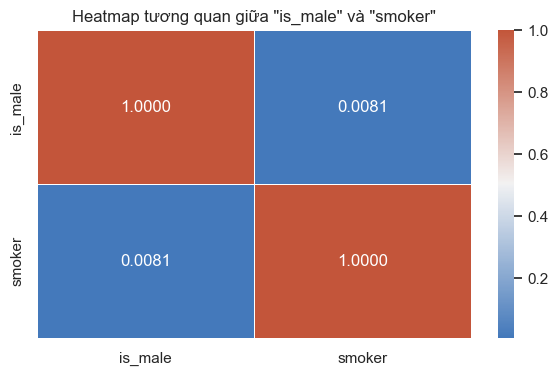

In [130]:
subset_df = df[['is_male', 'smoker']]
sex_smoker_corrmt = subset_df.corr()

plt.figure(figsize=(7, 4))
sns.heatmap(sex_smoker_corrmt, annot=True, cmap=sns.diverging_palette(250, 20, as_cmap=True), fmt='.4f', linewidths=0.5)
plt.title('Heatmap tương quan giữa "is_male" và "smoker"')
plt.show()

In [131]:
male_smoker = sex_smoker_crosstab.loc[1, 1]
male_non_smoker = sex_smoker_crosstab.loc[1, 0]
female_smoker = sex_smoker_crosstab.loc[0, 1]
female_non_smoker = sex_smoker_crosstab.loc[0, 0]

sex_smoker_df = pd.DataFrame({
    'is_male': ['Nam hút thuốc', 'Nam không hút thuốc',
                'Nữ hút thuốc', 'Nữ không hút thuốc'],
    'count': [male_smoker, male_non_smoker,
              female_smoker, female_non_smoker]
})

group_color = [sns.xkcd_rgb['light blue grey'], sns.xkcd_rgb['powder pink'],
               sns.xkcd_rgb['sky blue'], sns.xkcd_rgb['grapefruit']]
sex_smoker_labels = {
    'is_male': 'Nhóm',
    'count': 'Số lượng'
}

fig = px.pie(sex_smoker_df, names='is_male', values='count',
             title='Tỷ lệ giới tính theo lối sống hút thuốc',
             color_discrete_sequence=group_color, labels=sex_smoker_labels)
fig.update_layout(
    title_x=0.5,
    title_y=0.95,
    margin=dict(l=10, r=10, b=10, t=50),
    legend_orientation='h'
)
fig.show()

#### Kiểm định giả thuyết 6: Số lượng người nghiện nằm ở độ tuổi thanh thiếu niên (từ 13 tuổi đến dưới 20 tuổi) sử dụng bảo hiểm y tế bằng người trung niên (trên 40 tuổi đến dưới 60 tuổi)?
H0: Sự khác biệt về `chi phí y tế` giữa `nhóm thanh thiếu niên` có `sử dụng thuốc lá` và `nhóm người trung niên` có `sử dụng thuốc lá` là không đáng kể.

H1: Có sự khác biệt đáng kể về `chi phí y tế` giữa `nhóm thanh thiếu niên` có `sử dụng thuốc lá` và `nhóm người trung niên` có `sử dụng thuốc lá`.

In [133]:
juvenile_smoker = df[(df['age'] >= 18) & (df['age'] <= 29) &
                               (df['smoker'] == 1)]['charges'].dropna()
middle_aged_smoker = df[(df['age'] >= 30) & (df['age'] <= 49) &
                                    (df['smoker'] == 1)]['charges'].dropna()
juvenile_nonsmoker = df[(df['age'] >= 18) & (df['age'] <= 29) &
                                    (df['smoker'] == 0)]['charges'].dropna()
middle_aged_nonsmoker = df[(df['age'] >= 30) & (df['age'] <= 49) &
                                       (df['smoker'] == 0)]['charges'].dropna()

juvenile_smoker_array = np.array(juvenile_smoker)
middle_aged_smoker_array = np.array(middle_aged_smoker)

variance_juvenile_smoker = juvenile_smoker_array.var(ddof=1)
variance_middle_aged_smoker = middle_aged_smoker_array.var(ddof=1)

print(f'Phương sai của vị thành niên sử dụng thuốc lá:',
        f'{variance_juvenile_smoker:.2f}')
print(f'Phương sai của trung niên sử dụng thuốc lá:',
        f'{variance_middle_aged_smoker:.2f}')

Phương sai của vị thành niên sử dụng thuốc lá: 2176080663.51
Phương sai của trung niên sử dụng thuốc lá: 5935306530.30


In [134]:
alpha = 0.05
confidence_level = 1 - alpha
col1 = weightstats.DescrStatsW(juvenile_smoker_array)
col2 = weightstats.DescrStatsW(middle_aged_smoker_array)
cm_obj = weightstats.CompareMeans(col1, col2)
z, p_value = cm_obj.ztest_ind(usevar='unequal')
if p_value < alpha:
    print(f'Trị số p = {p_value} < {alpha} nên bác bỏ H0.',
          '\n=> Có sự khác biệt đáng kể về chi phí y tế giữa',
          'nhóm vị thành niên hút thuốc và nhóm trung niên hút thuốc.')
else:
    print(f'Trị số p = {p_value} >= {alpha} nên chấp nhận H0.',
          '\n=> Sự khác biệt về chi phí y tế giữa nhóm vị thành niên',
          'hút thuốc và nhóm trung niên hút thuốc là không đáng kể.')

Trị số p = 6.392351065716707e-10 < 0.05 nên bác bỏ H0. 
=> Có sự khác biệt đáng kể về chi phí y tế giữa nhóm vị thành niên hút thuốc và nhóm trung niên hút thuốc.


In [135]:
data = {
    'age_group': ['Vị thành niên', 'Trung niên'],
    'Có': [juvenile_smoker.mean(), middle_aged_smoker.mean()],
    'Không': [juvenile_nonsmoker.mean(), middle_aged_nonsmoker.mean()]
}
charges_lim = max(data['Có'] + data['Không']) * 1.2
df_bar = pd.DataFrame(data)
df_melted = pd.melt(df_bar, id_vars='age_group',
                    var_name='smoker', value_name='charges')

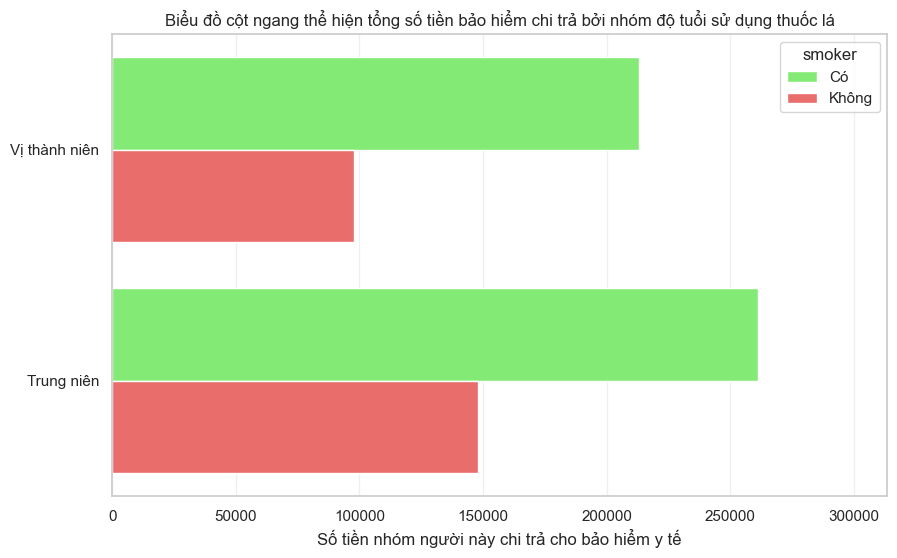

In [136]:
plt.figure(figsize=(10, 6))
plt.xlim(0, charges_lim)
plt.grid(axis='x', alpha=0.3)
sns.barplot(x='charges', y='age_group', hue='smoker', data=df_melted,
            palette={'Có': sns.xkcd_rgb['lighter green'], 'Không': sns.xkcd_rgb['grapefruit']})
plt.title('Biểu đồ cột ngang thể hiện tổng số tiền bảo hiểm chi trả bởi nhóm độ tuổi sử dụng thuốc lá')
plt.xlabel('Số tiền nhóm người này chi trả cho bảo hiểm y tế')
plt.ylabel('')
plt.show()

#### Kiểm định giả thuyết 7: Yếu tố hôn nhân gia đình có làm ảnh hưởng đến việc chi trả cho bảo hiểm y tế?

In [202]:
married = df.loc[df["married"] ==1]["charges"]
nmarried = df.loc[df["married"] ==0]["charges"]

In [203]:
print(f'Số quan sát của mẫu người đã kết hôn: {married.shape[0]}// Giá trị trung bình: {married.mean():.4f} ')
print(f'Số quan sát của mẫu người chưa kết hôn: {nmarried.shape[0]}// Giá trị trung bình: {nmarried.mean():.4f} ')

Số quan sát của mẫu người đã kết hôn: 864// Giá trị trung bình: 230817.7676 
Số quan sát của mẫu người chưa kết hôn: 475// Giá trị trung bình: 123126.9548 


In [204]:
print(f'Độ lệch chuẩn của tập người đã kết hôn: {married.std(ddof = 1):.4f}')
print(f'Độ lệch chuẩn của tập người chưa kết hôn: {nmarried.std(ddof =1):.4f}')
print(f'Độ chênh lệch của std: {abs(married.std()-nmarried.std()):4f}' )

Độ lệch chuẩn của tập người đã kết hôn: 95358.0402
Độ lệch chuẩn của tập người chưa kết hôn: 65483.2802
Độ chênh lệch của std: 29874.760057


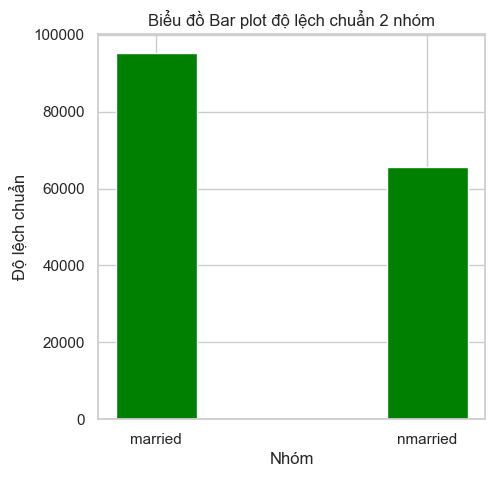

In [205]:
bar_plot = {'married' : married.std(ddof = 1 ), 'nmarried': nmarried.std(ddof = 1)}
fig = plt.figure(figsize = (5, 5))
courses = list(bar_plot.keys())
values = list(bar_plot.values())

plt.bar(courses, values, color ='green',  width = 0.3)
plt.xlabel("Nhóm")
plt.ylabel("Độ lệch chuẩn")
plt.title("Biểu đồ Bar plot độ lệch chuẩn 2 nhóm")
plt.show()

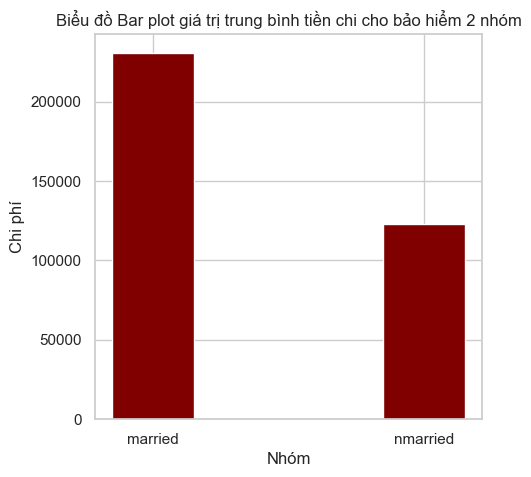

In [206]:
bar_plot = {'married' : married.mean(), 'nmarried': nmarried.mean()}
fig = plt.figure(figsize = (5, 5))
courses = list(bar_plot.keys())
values = list(bar_plot.values())

plt.bar(courses, values, color ='maroon',  width = 0.3)
plt.xlabel("Nhóm")
plt.ylabel("Chi phí")
plt.title("Biểu đồ Bar plot giá trị trung bình tiền chi cho bảo hiểm 2 nhóm")
plt.show()

In [207]:
print(f"Số quan sát trong bmi_stand: {bmi_stand.shape[0]}")
print(f"Số quan sát trong bmi_nstand: {bmi_nstand.shape[0]}")
print(f"Độ lệch chuẩn của bmi_stand: {bmi_stand.std(ddof=1):.4f}")
print(f"Độ lệch chuẩn của bmi_nstand: {bmi_nstand.std(ddof=1):.4f}")

Số quan sát trong bmi_stand: 355
Số quan sát trong bmi_nstand: 966
Độ lệch chuẩn của bmi_stand: 12.9298
Độ lệch chuẩn của bmi_nstand: 12.1274


In [209]:
bmi_stand = bmi_stand.dropna()
bmi_nstand = bmi_nstand.dropna()
smoker = smoker.dropna()
nsmoker = nsmoker.dropna()

In [210]:
print(bmi_stand.isnull().sum())
print(bmi_nstand.isnull().sum())
print(smoker.isnull().sum())
print(nsmoker.isnull().sum())

0
0
0
0


In [229]:
alpha = 0.05
married_cleaned = married.dropna()
nmarried_cleaned = nmarried.dropna()
z3, p3 = weightstats.ztest(married_cleaned, value=nmarried_cleaned.mean())
print(f'z-statistic: {z3}, p-value: {p3}')

z-statistic: 32.964093335169274, p-value: 2.657535047333261e-238


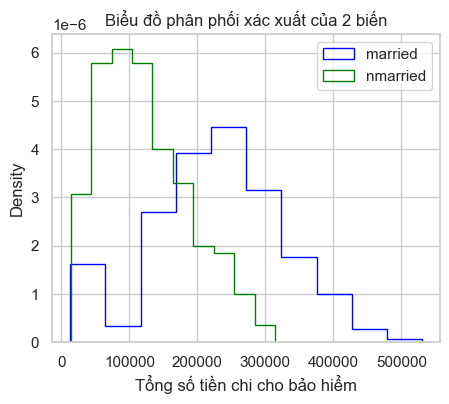

In [230]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
plt.hist(married, density = True, histtype = 'step', color = 'blue')
plt.hist(nmarried,  density = True, histtype = 'step', color = 'green')
plt.xlabel('Tổng số tiền chi cho bảo hiểm')
plt.ylabel('Density')
plt.title('Biểu đồ phân phối xác xuất của 2 biến')
plt.gca().legend(('married','nmarried'))
plt.show()

In [231]:
if (p3 < alpha):
    print(f'Trị số p = {p3:} < {alpha:.4f} bác bỏ H0 ==> Yếu tố hôn nhân có ảnh hưởng đến quyết định làm mới bảo hiểm')
else:
    print(f'Trị số p = {p3:} >= {alpha:.4f} KHÔNG bác bỏ H0 => Yếu tố hôn nhân không ảnh hưởng đến quyết định làm mới bảo hiểm ')

Trị số p = 2.657535047333261e-238 < 0.0500 bác bỏ H0 ==> Yếu tố hôn nhân có ảnh hưởng đến quyết định làm mới bảo hiểm


#### Kiểm định giả thuyết 8: Lối sống nghiện thuốc có làm ảnh hưởng đến việc làm mới bảo hiểm y tế?

In [232]:
smoker = df.loc[df["smoker"] ==1]["insur_renewals"]
nsmoker = df.loc[df["smoker"]==0]["insur_renewals"]

In [233]:
print(f'Số quan sát của mẫu người nghiện thuốc: {smoker.shape[0]}// Giá trị trung bình: {smoker.mean():.4f} ')
print(f'Số quan sát của mẫu người không nghiện thuốc: {nsmoker.shape[0]}// Giá trị trung bình: {nsmoker.mean():.4f} ')

Số quan sát của mẫu người nghiện thuốc: 369// Giá trị trung bình: 20.8733 
Số quan sát của mẫu người không nghiện thuốc: 970// Giá trị trung bình: 24.2411 


In [234]:
print(f'Độ lệch chuẩn của tập người nghiện thuốc: {smoker.std(ddof = 1):.4f}')
print(f'Độ lệch chuẩn của tập người không nghiện thuốc: {nsmoker.std(ddof =1):.4f}')
print(f'Độ chênh lệch của std: {abs(smoker.std()-nsmoker.std()):4f}' )

Độ lệch chuẩn của tập người nghiện thuốc: 12.6277
Độ lệch chuẩn của tập người không nghiện thuốc: 12.7654
Độ chênh lệch của std: 0.137648


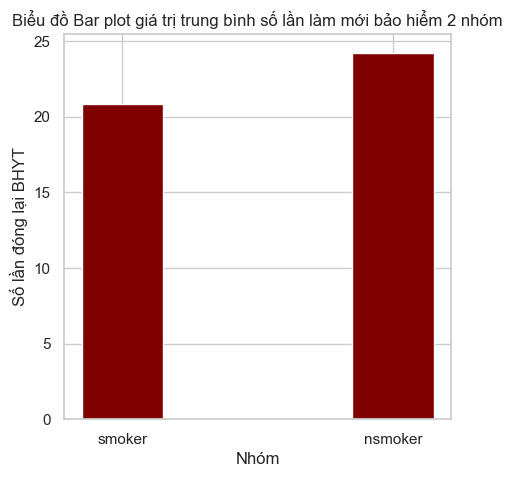

In [235]:
bar_plot = {'smoker' : smoker.mean(), 'nsmoker': nsmoker.mean()}
courses = list(bar_plot.keys())
values = list(bar_plot.values())
fig = plt.figure(figsize = (5, 5))

plt.bar(courses, values, color ='maroon',  width = 0.3)
plt.xlabel("Nhóm")
plt.ylabel("Số lần đóng lại BHYT")
plt.title("Biểu đồ Bar plot giá trị trung bình số lần làm mới bảo hiểm 2 nhóm")
plt.show()

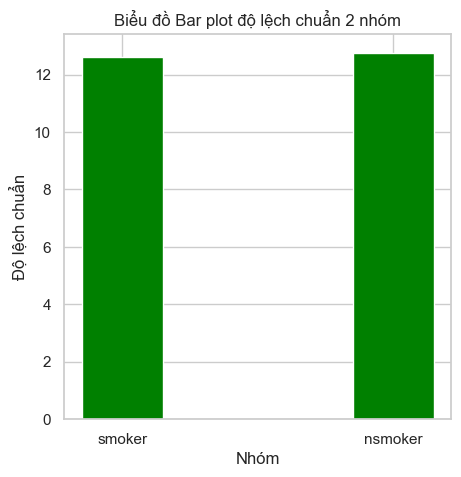

In [236]:
bar_plot = {'smoker' : smoker.std(ddof = 1 ), 'nsmoker': nsmoker.std(ddof = 1)}
courses = list(bar_plot.keys())
values = list(bar_plot.values())
fig = plt.figure(figsize = (5, 5))

plt.bar(courses, values, color ='green',  width = 0.3)
plt.xlabel("Nhóm")
plt.ylabel("Độ lệch chuẩn")
plt.title("Biểu đồ Bar plot độ lệch chuẩn 2 nhóm")
plt.show()

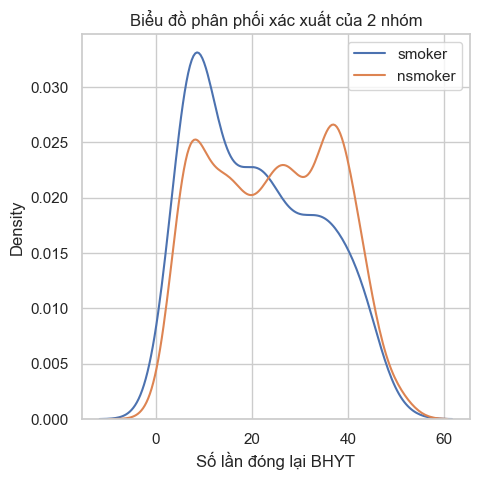

In [237]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.distplot(smoker, kde = True, norm_hist = True, hist = False)
sns.distplot(nsmoker, kde = True, norm_hist = True, hist = False)
plt.xlabel('Số lần đóng lại BHYT')
plt.ylabel('Density')
plt.title('Biểu đồ phân phối xác xuất của 2 nhóm')
plt.gca().legend(('smoker','nsmoker'))
plt.show()

In [241]:
smoker_cleaned = smoker.dropna()
nsmoker_cleaned = nsmoker.dropna()

alpha = 0.05
z2, p2 = weightstats.ztest(smoker_cleaned, value=nsmoker_cleaned.mean(), alternative="larger")

In [242]:
if (p2 < alpha):
    print(f'Trị số p = {p2:2f} < {alpha:.4f} bác bỏ H0',
          '==> Người có lối sống hút thuốc có xu hướng làm mới bảo hiểm y tế nhiều hơn người bình thường')
else:
    print(f'Trị số p = {p2:2f} >= {alpha:.4f} KHÔNG bác bỏ H0',
          '==> Người có lối sống hút thuốc có xu hướng làm mới bảo hiểm y tế ít hơn người bình thường')

Trị số p = 1.000000 >= 0.0500 KHÔNG bác bỏ H0 ==> Người có lối sống hút thuốc có xu hướng làm mới bảo hiểm y tế ít hơn người bình thường
